In [1]:
import scipy
import pandas
import sympy

import numpy as np

from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
fichiers = ['sans_bebe.xlsx', 'avec_bebe.xlsx']
données = [pandas.read_excel(fichier) for fichier in fichiers]

# Aperçu

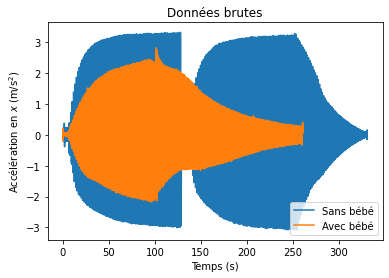

In [4]:
données[0].set_index('Time (s)').iloc[:, 0].plot(label='Sans bébé')
données[1].set_index('Time (s)').iloc[:, 0].plot(label='Avec bébé')
plt.legend()
plt.title('Données brutes')
plt.ylabel('Accélération en $x$ (m/s$^2$)')
plt.xlabel('Temps (s)')
plt.savefig('brutes.svg')
plt.show()

# Fonction d'estimation des paramètres

La fonction `estimé` ci bas prend en argument un modèle `fonction` dont les paramètres aux valeurs initiales `params` seront optimisés par la fonction `scipy.optimize.curve_fit`. `temps_min` et `temps_max` indiquent l'intervalle à considérer pour la modélisation, et `données` est un objet `pandas.DataFrame` contenant une table de valeurs d'accélération telles que mesurées avec PhyPhox.

In [5]:
def estimé(fonction, temps_min, temps_max, données, *params):
    condition = (données['Time (s)'] > temps_min) & (données['Time (s)'] < temps_max)
    courbe = données.loc[condition, :].iloc[:, :2].set_index('Time (s)').astype('float')
    courbe.index = courbe.index.astype('float')
    if not params:
        params = None
    else:
        params = np.array(params, dtype='float64')
    params = curve_fit(fonction, courbe.index-min(courbe.index), courbe.iloc[:, 0], params, bounds=[[0, 0, 0, 0], [np.inf, np.inf, np.inf, 2*np.pi]])[0]
    
    ts = np.arange(courbe.index[0], courbe.index[-1], (courbe.index[-1] - courbe.index[0])/len(courbe.index)) - min(courbe.index)
    xs = fonction(ts, *params)
    
    plt.plot(courbe, color='blue')
    plt.plot(ts+min(courbe.index), xs, '--')
    
    return params

# Modèles

In [6]:
A = sympy.Symbol('A')
gamma = sympy.Symbol('gamma')
omega = sympy.Symbol('omega')
phi = sympy.Symbol('phi')
t = sympy.Symbol('t')

In [7]:
x_f = A * sympy.exp(-gamma*t/2) * sympy.cos(omega*t - phi)
x_f_dot = sympy.diff(x_f, t).simplify()
x_f_ddot = sympy.diff(x_f_dot, t).simplify()
modèle_freiné = sympy.lambdify([t, A, gamma, omega, phi], x_f_ddot, 'numpy')

In [8]:
x_e = A * (1 - sympy.exp(-gamma*t/2)) * sympy.cos(omega*t - phi)
x_e_dot = sympy.diff(x_e, t).simplify()
x_e_ddot = sympy.diff(x_e_dot, t).simplify()
modèle_entraîné = sympy.lambdify([t, A, gamma, omega, phi], x_e_ddot, 'numpy')

# Estimation des paramètres

In [9]:
# Estimé des paramètres (visuel)
gamma_estimé = 2 / 30
omega_estimé = 2 * np.pi / 90 * 50
A_estimé = abs(données[0].iloc[:, 1].max() / (gamma_estimé**2 - 4*omega_estimé**2) * 4)
phi_estimé = 0
params_estimé = (A_estimé, gamma_estimé, omega_estimé, phi_estimé)
print('A = {0}\n\\gamma = {1}\n\\omega = {2}\n\\phi = {3}'.format(*params_estimé))

A = 0.27270106671187944
\gamma = 0.06666666666666667
\omega = 3.490658503988659
\phi = 0


# Modélisation

## Sans bébé

A_f = 0.1975240655676513
\gamma_f = 0.07132319871739125
\omega_f = 4.1983294338117885
\phi_f = 4.352809133841838
A_t = 0.17367538629061022
\gamma_t = 0.1778748367929816
\omega_t = 4.0499145800256455
\phi_t = 0.29474286610594
A_e = 0.18447913125120108
\gamma_e = 0.1504662103700895
\omega_e = 4.0505735149461035
\phi_e = 0.3070298155160951


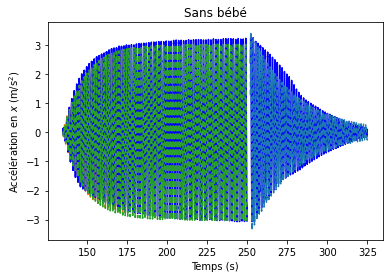

In [10]:
params_freiné = estimé(modèle_freiné, 252, 325, données[0], *params_estimé)
print('A_f = {0}\n\\gamma_f = {1}\n\\omega_f = {2}\n\\phi_f = {3}'.format(*params_freiné))

params_transitoire = estimé(modèle_entraîné, 135, 175, données[0], *params_freiné)
print('A_t = {0}\n\\gamma_t = {1}\n\\omega_t = {2}\n\\phi_t = {3}'.format(*params_transitoire))
#params_stable = estimé(modèle_entraîné, 200, 250, données[0], *params_transitoire)
#print('A_s = {0}\n\\gamma_s = {1}\n\\omega_s = {2}\n\\phi_s = {3}'.format(*params_stable))

params_entraîné = estimé(modèle_entraîné, 135, 250, données[0], *params_transitoire)
print('A_e = {0}\n\\gamma_e = {1}\n\\omega_e = {2}\n\\phi_e = {3}'.format(*params_entraîné))

plt.title('Sans bébé')
plt.ylabel('Accélération en $x$ (m/s$^2$)')
plt.xlabel('Temps (s)')
plt.savefig('sans_bebe.svg')

## Avec bébé

A_f = 0.1383752398078524
\gamma_f = 0.02547821839403991
\omega_f = 3.979654438900909
\phi_f = 3.137033341235566
A_t = 0.11552221987313761
\gamma_t = 0.1792212824621064
\omega_t = 3.9512357254111645
\phi_t = 5.923378255067154e-16
A_e = 0.14034233609992106
\gamma_e = 0.10847446271958036
\omega_e = 3.9461382408416608
\phi_e = 1.6874118412519057e-16


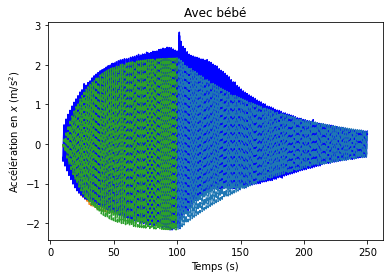

In [11]:
params_bebe_freiné = estimé(modèle_freiné, 100, 250, données[1], *params_estimé)
print('A_f = {0}\n\\gamma_f = {1}\n\\omega_f = {2}\n\\phi_f = {3}'.format(*params_bebe_freiné))

params_bebe_transitoire = estimé(modèle_entraîné, 10, 50, données[1], *params_bebe_freiné)
print('A_t = {0}\n\\gamma_t = {1}\n\\omega_t = {2}\n\\phi_t = {3}'.format(*params_bebe_transitoire))

params_bebe_entraîné = estimé(modèle_entraîné, 10, 100, données[1], *params_bebe_transitoire)
print('A_e = {0}\n\\gamma_e = {1}\n\\omega_e = {2}\n\\phi_e = {3}'.format(*params_bebe_entraîné))

plt.title('Avec bébé')
plt.ylabel('Accélération en $x$ (m/s$^2$)')
plt.xlabel('Temps (s)')
plt.savefig('avec_bebe.svg')